In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [19]:
train_dir="AI_detection_data/train"
test_dir="AI_detection_data/test"
lst=["AI_detection_data/train/REAL","AI_detection_data/train/FAKE","AI_detection_data/test/REAL","AI_detection_data/test/FAKE"]

 size: 50000


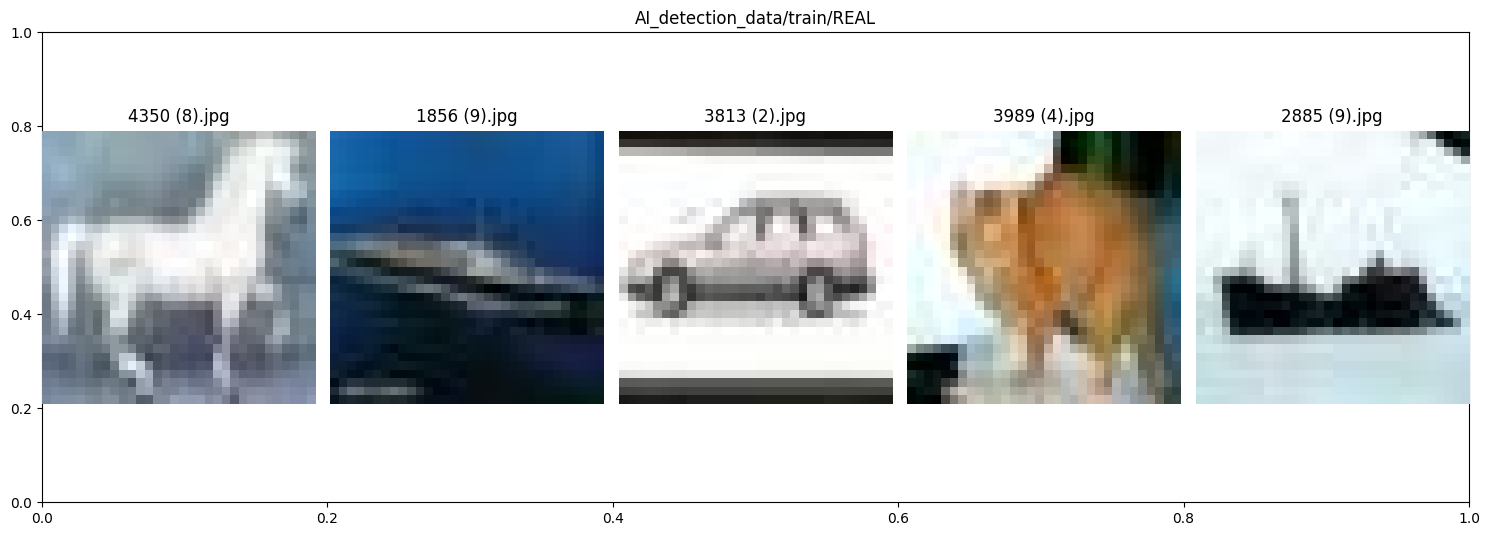

 size: 50000


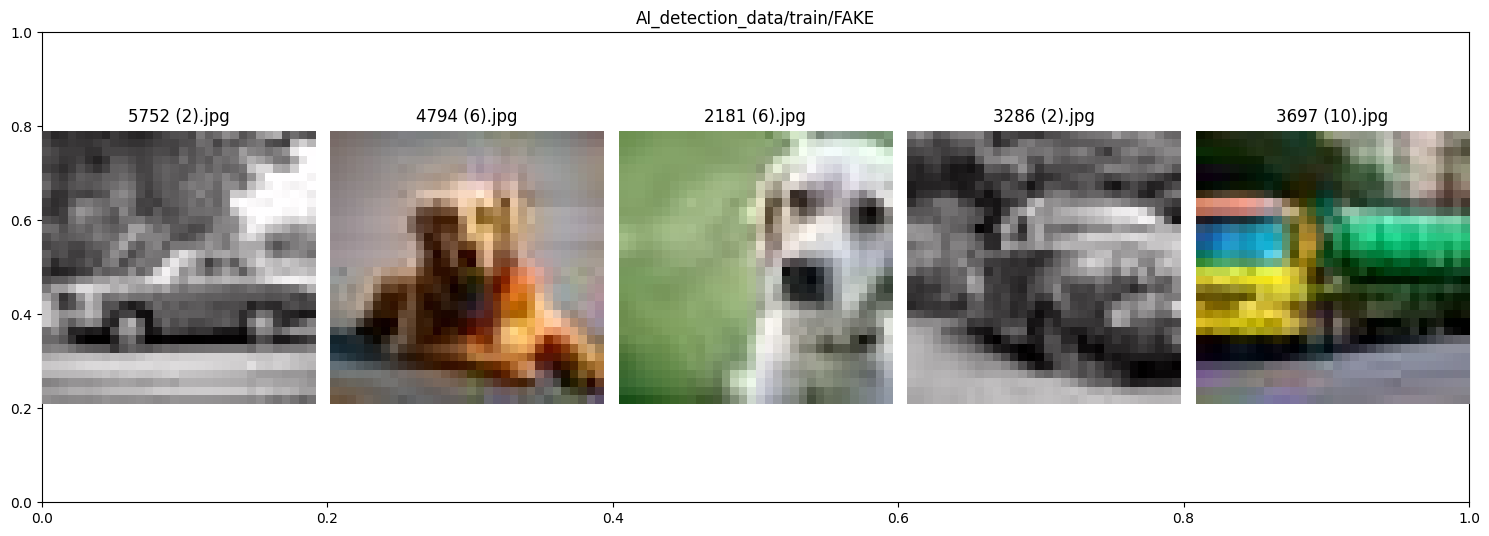

 size: 10000


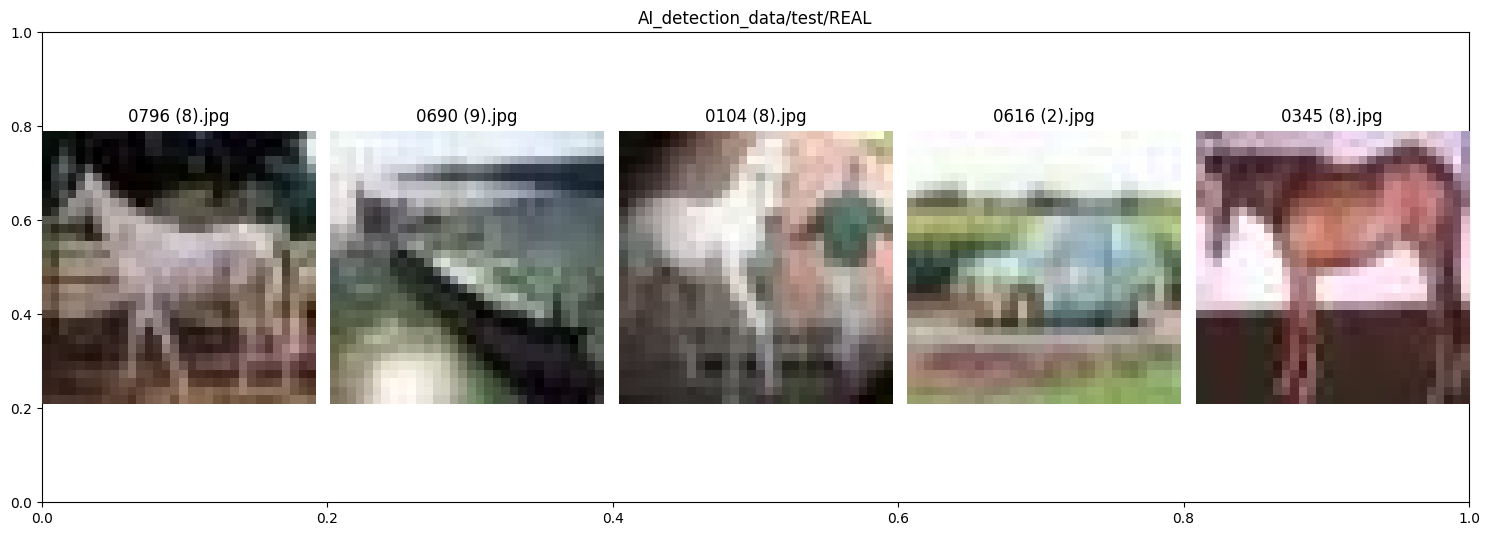

 size: 10000


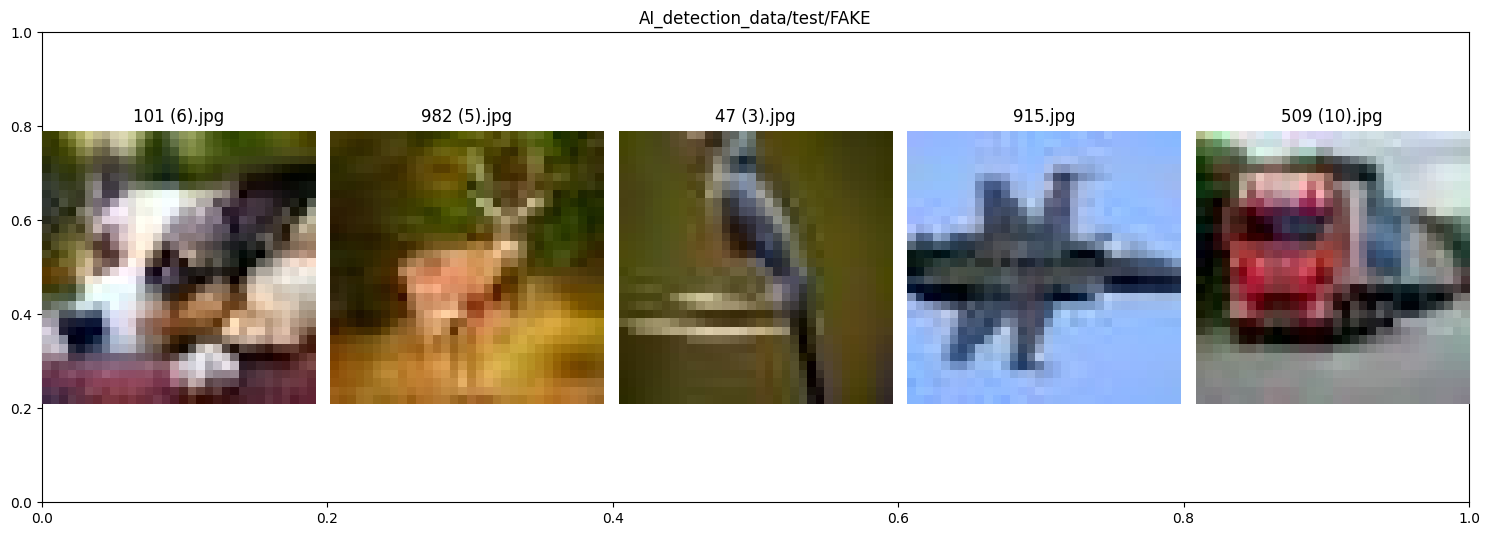

In [32]:

valid = ('.jpg', '.jpeg', '.png')

for i in lst:
  all_img = [file for file in os.listdir(i) if file.lower().endswith(valid)]

  print(f" size: {len(all_img)}")
  num_img = 5
  ran_img = random.sample(all_img, num_img)
  plt.figure(figsize=(15, 5))
  plt.title(i)
  for idx, name in enumerate(ran_img):
      img_path = os.path.join(i, name)
      img = Image.open(img_path)

      plt.subplot(1, num_img, idx + 1)
      plt.imshow(img)
      plt.title(name)
      plt.axis('off')
  
  plt.tight_layout()
  plt.show()


In [54]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)


In [55]:
print(train_data.classes)
print(train_data.class_to_idx)

['FAKE', 'REAL']
{'FAKE': 0, 'REAL': 1}


In [56]:
print(test_data.classes)
print(test_data.class_to_idx)

['FAKE', 'REAL']
{'FAKE': 0, 'REAL': 1}


In [87]:
test_data

Dataset ImageFolder
    Number of datapoints: 20000
    Root location: AI_detection_data/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [88]:
train_data

Dataset ImageFolder
    Number of datapoints: 100000
    Root location: AI_detection_data/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [57]:
len(train_data)

100000

In [58]:
len(test_data)

20000

In [59]:
len(test_loader)

625

In [60]:
len(train_loader)

3125

In [101]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, len(train_data.classes))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

In [103]:
device

device(type='cuda')

In [104]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [105]:
model

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [66]:
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

In [67]:
epochs = 2
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        predicted = torch.max(outputs, 1)[1]
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Acc:{train_accuracy:.2f}")


Epoch 1/2, Loss: 0.2759, Acc:88.13
Epoch 2/2, Loss: 0.1681, Acc:93.37


In [68]:
def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    count0 = 0
    count1 = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            pred = model(images)
            predicted = torch.max(pred, 1)[1]
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            count0 += (predicted == 0).sum().item()
            count1 += (predicted == 1).sum().item()

    accuracy = 100 * correct / total
    return accuracy, count0, count1

test_accuracy, test_count0, test_count1 = evaluate_model(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Count of class 0: {test_count0}, Count of class 1: {test_count1}")

train_accuracy, train_count0, train_count1 = evaluate_model(model, train_loader, device)
print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Count of class 0: {train_count0}, Count of class 1: {train_count1}")


Test Accuracy: 94.26%
Count of class 0: 9704, Count of class 1: 10296
Train Accuracy: 95.05%
Count of class 0: 48529, Count of class 1: 51471


In [ ]:
len(train_accuracies) #only 2 epoch

2

In [73]:
torch.save(model, 'model_3.pth')


In [89]:
epoch=[1,2]

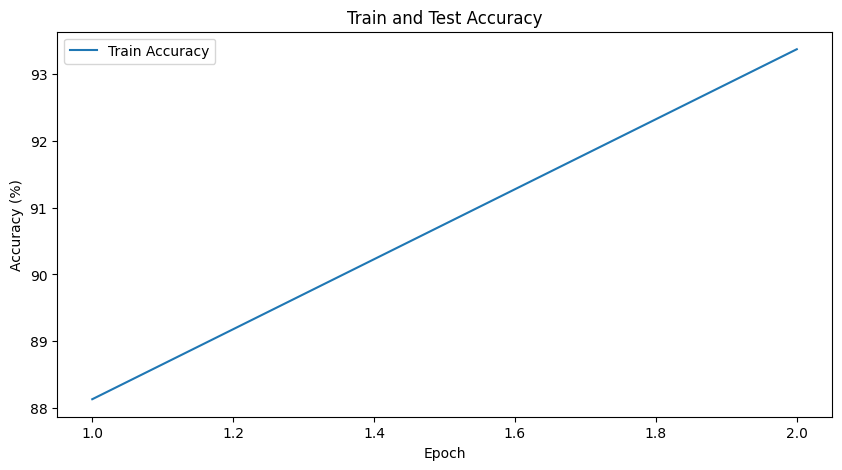

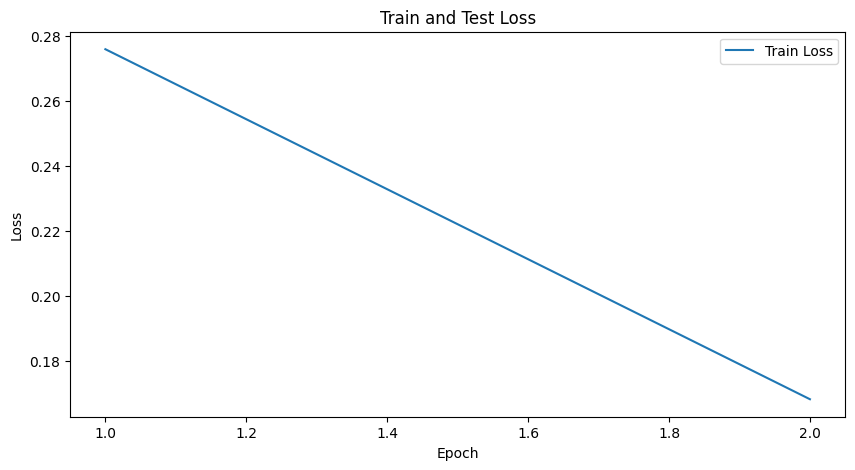

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epoch,train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epoch,train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.show()


#can still going next try 5 epochs


In [106]:
epochs = 10
train_accuracies, train_losses = [], []
test_accuracies, test_losses = [], []

for epoch in range(epochs):

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = torch.max(outputs, 1)[1]
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            predicted = torch.max(outputs, 1)[1]
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    test_loss /= len(test_loader)
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch 1/10
Train Loss: 0.2718, Train Accuracy: 88.34%
Test Loss: 0.1997, Test Accuracy: 92.04%
Epoch 2/10
Train Loss: 0.1695, Train Accuracy: 93.31%
Test Loss: 0.2045, Test Accuracy: 91.80%
Epoch 3/10
Train Loss: 0.1382, Train Accuracy: 94.66%
Test Loss: 0.1418, Test Accuracy: 94.32%
Epoch 4/10
Train Loss: 0.1170, Train Accuracy: 95.50%
Test Loss: 0.1430, Test Accuracy: 94.75%
Epoch 5/10
Train Loss: 0.0996, Train Accuracy: 96.23%
Test Loss: 0.1423, Test Accuracy: 95.07%
Epoch 6/10
Train Loss: 0.0820, Train Accuracy: 96.94%
Test Loss: 0.1447, Test Accuracy: 94.92%
Epoch 7/10
Train Loss: 0.0702, Train Accuracy: 97.44%
Test Loss: 0.1420, Test Accuracy: 95.13%
Epoch 8/10
Train Loss: 0.0601, Train Accuracy: 97.77%
Test Loss: 0.1570, Test Accuracy: 94.76%
Epoch 9/10
Train Loss: 0.0521, Train Accuracy: 98.14%
Test Loss: 0.1619, Test Accuracy: 94.89%
Epoch 10/10
Train Loss: 0.0450, Train Accuracy: 98.37%
Test Loss: 0.1621, Test Accuracy: 94.79%


In [108]:
lepoch=[]

In [109]:
for i in range(1,11):
    lepoch.append(i)

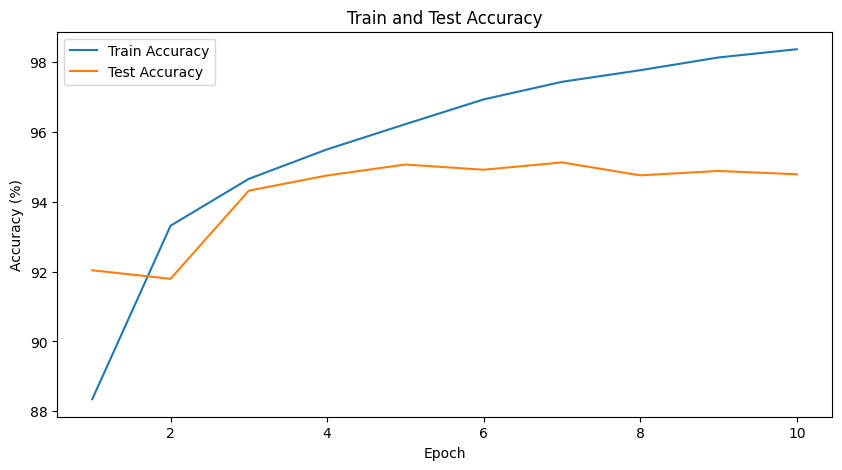

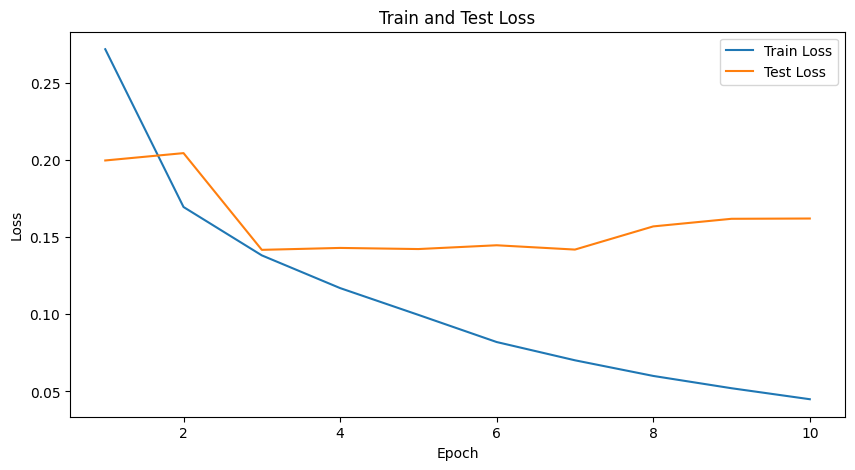

In [110]:

plt.figure(figsize=(10, 5))
plt.plot(lepoch,train_accuracies, label='Train Accuracy')
plt.plot(lepoch,test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(lepoch,train_losses, label='Train Loss')
plt.plot(lepoch,test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.show()


probably stop at 3 or 4 epoch will be the best to avoid overfitting

In [111]:
torch.save(model, 'model_4.pth')


In [112]:
torch.save(model.state_dict(), 'sd_model_4.pth')
